In [1]:
import pandas as pd
import re
import numpy as np
import src.textcleaning as txfn
import src.datecleaning as dtfn
import datetime

In [2]:
file = pd.read_csv("inputs/attacks.csv", encoding = "latin-1")

### depuramos los nombres de las columnas para eliminar valores con espacios al final

In [3]:
file.columns = list(map(lambda e : txfn.text_clean_last_spaces(e),file.columns))

In [4]:
(file[["Case Number"]] == 0).value_counts()

Case Number
False          25723
dtype: int64

### limpiamos la tabla y quitamos las filas cuyos valores son nulos en la columna case number

In [5]:
file_clean = file[~file["Case Number"].isnull()]

### eliminamosvalores Nan y que empiecen por x de la columna anterior

In [6]:
file_clean = file_clean[~file_clean["Case Number"].str.contains("x", na=False )]

### igual que antes, pero valores que empiecen por 0

In [7]:
file_clean = file_clean[~file_clean["Case Number"].str.startswith("0")]

### reseteamos el index para poder tener in undice mas manejable que el case number y eliminamos dicha columna

In [8]:
file_clean = file_clean.reset_index()
del file_clean["Case Number"]

### aplicamos una formula que me limpia la mayor parte de la columna Date, y me lo separa en años y hago lo mismo para los meses

In [9]:
file_clean["Month"] = [dtfn.date_month(dtfn.date_cleaner(s)) for s in file_clean["Date"]]
file_clean["Year"] = [dtfn.date_year(dtfn.date_cleaner(s)) for s in file_clean["Date"]]

In [10]:
file_clean["Year"].count()

6293

### limpiamos algunas filas especificas que por la conversion y formatos no se limpian bien o fechas mayores a las de este año

In [11]:
file_clean = file_clean[(file_clean["Year"] != 0)]
file_clean = file_clean[file_clean["Year"] != "Feb"]
file_clean = file_clean[(file_clean["Year"] != "")]
file_clean = file_clean[(file_clean["Year"] != "t937")]
file_clean = file_clean[(file_clean["Year"] != "May2")]
file_clean = file_clean[(file_clean["Year"] != "Nov2")]
file_clean = file_clean[(file_clean["Year"] != "Jan")]
file_clean = file_clean[(file_clean["Year"] != "May")]
file_clean = file_clean[(file_clean["Year"] != "Dec")]
file_clean = file_clean[(file_clean["Year"] != "April")]
file_clean = file_clean[(file_clean["Year"] != "Decp")]
file_clean = file_clean[(file_clean["Year"] < "2020")]

### limpiamos unas pocas filasque acaban con el año en "," o "s" con una pequeña formula

In [12]:
file_clean["Year"] = list(map(lambda e : txfn.coma_clean(e),file_clean["Year"]))

In [13]:
file_clean["Year"].count()

5384

### sacamos las columnas que tenemos y luego reordenamos estas en el orden que queremos

In [14]:
file_clean.columns

Index(['index', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23', 'Month'],
      dtype='object')

In [15]:
file_clean = file_clean[['index', 'Date','Month', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23']]

### creamos un dataset mas pequeño, con menos columnas para que sea mas manejable

In [16]:
file_clean = file_clean[["index","Month","Year", "Country","Sex", "Fatal (Y/N)","Injury","Age", "Name"]]

#verificamos cuantos valores nulos tenemos por columnas

In [17]:
file_clean["index"].isnull().value_counts()

False    5384
Name: index, dtype: int64

In [18]:
file_clean["Month"].isnull().value_counts()

False    5384
Name: Month, dtype: int64

In [19]:
file_clean["Year"].isnull().value_counts()

False    5384
Name: Year, dtype: int64

In [20]:
file_clean["Country"].isnull().value_counts()

False    5353
True       31
Name: Country, dtype: int64

In [21]:
file_clean["Sex"].isnull().value_counts()

False    4954
True      430
Name: Sex, dtype: int64

In [22]:
file_clean["Fatal (Y/N)"].isnull().value_counts()

False    4925
True      459
Name: Fatal (Y/N), dtype: int64

In [23]:
file_clean["Age"].isnull().value_counts()

False    3283
True     2101
Name: Age, dtype: int64

In [24]:
file_clean.head()

,index,Month,Year,Country,Sex,Fatal (Y/N),Injury,Age,Name
0,0,Jun,2018,USA,F,N,"No injury to occupant, outrigger canoe and pad...",57,Julie Wolfe
1,1,Jun,2018,USA,F,N,Minor injury to left thigh,11,Adyson McNeely
2,2,Jun,2018,USA,M,N,Injury to left lower leg from surfboard skeg,48,John Denges
3,3,Jun,2018,AUSTRALIA,M,N,Minor injury to lower leg,NaN,male
4,4,Jun,2018,MEXICO,M,N,Lacerations to leg & hand shark PROVOKED INCIDENT,NaN,Gustavo Ramos


### aplicamos una formula para determinar valores Y/N en columna Fatal (nueva) para poder analizar muertes por tiburones

In [25]:
file_clean["Fatal"] = list(map(lambda row: txfn.fatal(row),np.array(file_clean[["Fatal (Y/N)","Injury"]])))

In [26]:
file_clean["Fatal"].value_counts()

N    4284
Y    1100
Name: Fatal, dtype: int64

In [27]:
file_clean.Country = list(map(lambda x: txfn.country(x), file_clean.Country))

# Hipotesis1 : los paises desarrollados tienen menores indices de mortalidad por tiburones

## mortalidad por paises

In [28]:
plot1 = file_clean[["Year", "Country", "Fatal"]]

In [29]:
attacks = plot1.groupby(["Country"]).agg({"Fatal":"count"})

In [30]:
attacks.columns = ["Attacks"]

In [31]:
deaths = file_clean[file_clean["Fatal"] == "Y"]

In [32]:
deaths = deaths.groupby(["Country"]).agg({"Fatal": "count"})

In [33]:
deaths.columns = ["Deaths"]

In [34]:
total_deaths = pd.concat([attacks,deaths], axis =1)

In [35]:
total_deaths = total_deaths[~total_deaths["Deaths"].isnull()]

<AxesSubplot:>

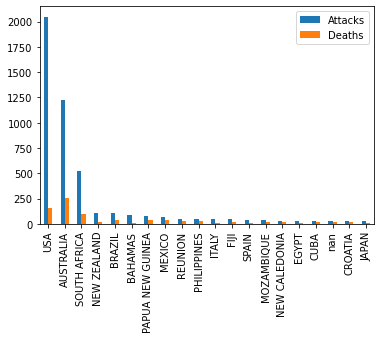

In [36]:
total_deaths.sort_values("Attacks", ascending = False).head(20).plot.bar()

In [37]:
total_deaths.head()

,Attacks,Deaths
PHILIPPINES,1,1.0
TONGA,3,2.0
AFRICA,1,1.0
AMERICAN SAMOA,3,3.0
ANDAMAN / NICOBAR ISLANDAS,1,1.0


In [38]:
percentage = (total_deaths.Deaths/total_deaths.Attacks)*100

In [39]:
total_deaths = pd.concat([total_deaths,percentage],axis = 1)

In [40]:
total_deaths.columns = ['Attacks', 'Deaths', "Percentage"]

In [41]:
plot = total_deaths.sort_values("Attacks", ascending= False)
plot.head()

,Attacks,Deaths,Percentage
USA,2048,156.0,7.617188
AUSTRALIA,1226,258.0,21.044046
SOUTH AFRICA,522,97.0,18.582375
NEW ZEALAND,110,20.0,18.181818
BRAZIL,106,37.0,34.905660


<AxesSubplot:>

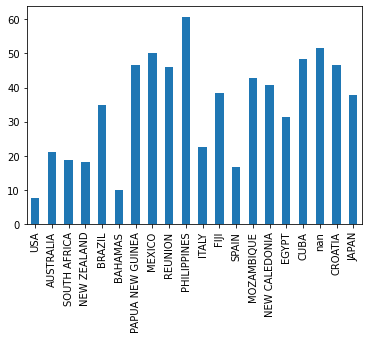

In [42]:
plot["Percentage"].head(20).plot.bar()

In [43]:
file_clean.columns

Index(['index', 'Month', 'Year', 'Country', 'Sex', 'Fatal (Y/N)', 'Injury',
       'Age', 'Name', 'Fatal'],
      dtype='object')

# Hipotesis2: los paises avanzados han mejorado sus numeros

In [44]:
monthly = file_clean[['index', 'Month', 'Year', 'Country', 'Sex','Fatal']]

In [45]:
monthly["Month"] = list(map(lambda x: txfn.month(x), monthly["Month"]))

<ipython-input-45-72226cba711a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly["Month"] = list(map(lambda x: txfn.month(x), monthly["Month"]))


In [46]:
EEUU = monthly[monthly.Country == "USA"]

In [47]:
EEUU = EEUU[(EEUU["Fatal"] == "Y")]

In [48]:
EEUU2 = monthly[monthly.Country == "USA"]

In [49]:
EEUU2 = EEUU2.groupby(["Year"]).agg({"Fatal": "count"})
EEUU2.rename(columns = {"Fatal": "Attacks"}, inplace = True)

In [50]:
plot2 = EEUU.groupby(["Year"]).agg({"Fatal": "count"})

In [51]:
plot2 = pd.concat([plot2, EEUU2], axis=1)

In [52]:
plot2.head()

,Fatal,Attacks
1751,1.0,1
1771,1.0,1
1780,1.0,1
1810,1.0,1
1817,1.0,1


In [53]:
plot2 = plot2.dropna()

In [54]:
plot2 = plot2.reset_index()

In [55]:
plot2.sort_values(["index"], ascending = False).head()

,index,Fatal,Attacks
100,2015,1.0,72
99,2013,2.0,59
98,2012,1.0,63
97,2010,2.0,39
96,2009,2.0,41


/home/borja/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='index'>

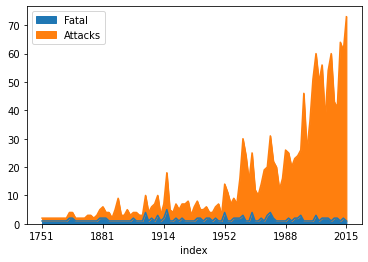

In [56]:
plot2.plot.area(x= "index")

In [57]:
Australia = monthly[monthly.Country == "AUSTRALIA"]

In [58]:
Australia = Australia[(Australia["Fatal"] == "Y")]

In [59]:
Australia2 = monthly[monthly.Country == "AUSTRALIA"]

In [60]:
Australia2 = Australia2.groupby(["Year"]).agg({"Fatal": "count"})
Australia2.rename(columns = {"Fatal": "Attacks"}, inplace = True)

In [61]:
plot3 = Australia.groupby(["Year"]).agg({"Fatal": "count"})

In [62]:
plot3 = pd.concat([plot3, Australia2], axis=1)

In [63]:
plot3 = plot3.reset_index()

In [64]:
plot3.head()

,index,Fatal,Attacks
0,1837,1.0,1
1,1841,1.0,1
2,1845,1.0,1
3,1849,3.0,4
4,1852,1.0,2


In [65]:
plot3 = plot3.sort_values(["index"], ascending=True)

/home/borja/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='index'>

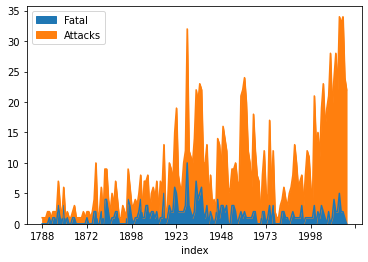

In [66]:
plot3.plot.area(x = "index")